## 1.2.5b. Pearson correlation Nestorowa dataset

In this Notebook we will compare our dataset with the another published dataset, namely the dataset published in Nestorowa et al. 2016 (https://doi.org/10.1182/blood-2016-05-716480
). Their preprocessed and filtered count matrix can be found using GEO code GSE81682 (https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE81682). Here, you can download the GSE81682_HTSeq_counts.txt.gz file.

In Notebook 1.2.5a we compared the control subset with the Nestorowa dataset by plotting both in one UMAP. Here, we will focus on the Pearson correlation between the clusters in both datasets. In order to do this we need the preprocessed datasets, but we will not batch correct them. 

In [1]:
### loading python libraries

# standard libraries
import numpy as np
import pandas as pd

# single cell libraries
import anndata as ad
import scanpy as sc
sc.settings.verbosity = 0 

# plotting libraries
from matplotlib import pyplot as plt
import seaborn as sns; sns.set_theme() #for plotting the heatmap
plt.rcParams['pdf.fonttype'] = 42 #for saving PDF with changeable text
plt.rcParams['ps.fonttype'] = 42 #for saving PDF with changeable text

# other 
import warnings
warnings.filterwarnings('ignore') #ignore filter warnings
import sklearn as sk #used for L2 normalization
import sklearn.preprocessing #used for L2 normalization
import scipy #for making sparse matrix from dense
from scipy.cluster.hierarchy import linkage, leaves_list #for hiearchical clustering
from scipy.spatial.distance import pdist #for hiearchical clustering

# import own functions
from utils import *

### Load data

First, we load the preprocessed control subset (as preprocessed in notebook 1.1).

In [2]:
### load Anndata object with the control subset 
adata_path = "../data/count_matrices/control_filtered.h5ad"
adata = sc.read_h5ad(adata_path)

Then, we load the Nestorowa data. The genes in the Nestorowa dataset are named with their Ensembl gene ID. Because the genes in our own dataset are named using their gene names, we will convert the ENSEMBL gene IDs to gene names.

To do so, we will use the package mygene and convert each ENSEMBL ID to it's corresponding gene name. This takes quite some time, so we commented the code out and instead, we recommend you to just use the csv file we uploaded on the Github Repository ("data/public_datasets/Nestorowa_2016/ENSMBL_and_gene_names.csv"). 

In [3]:
### load Nestorowa data in dataframe
nesto_data_path = "../data/public_datasets/Nestorowa_2016/HTSeq_counts.txt"
nesto_data = pd.read_csv(nesto_data_path, index_col=0, sep="\t")
nesto_data = nesto_data.T

In [4]:
### remove rows that are not genes
nesto_data = nesto_data.iloc[:,nesto_data.columns.str.startswith('ENSMUS')]

In [5]:
### convert ENSEMBL IDs to gene names
#mg = mygene.MyGeneInfo()
#genes_list = list(nesto_data.columns)
#conversion_table = mg.querymany(genes_list , scopes='ensemblgene',
#                                fields='symbol', species='mouse',
#                                as_dataframe=True, verbose=False)

### remove duplicates in converstion table
#conversion_table = conversion_table.drop_duplicates(subset="query", keep="first")

### save ENSEMBL IDs and gene names for future uses
#save_path = "../data/public_datasets/Nestorowa_2016/ENSMBL_and_gene_names.csv"
#conversion_table.to_csv(save_path, header=True, index=True)

In [6]:
### load tabel vor ENSEMBL ID to gene name conversion
gene_conversion_path = "../data/public_datasets/Nestorowa_2016/ENSMBL_and_gene_names.csv"
conversion_table = pd.read_csv(gene_conversion_path, index_col=1)

In [7]:
### exchange ENSEMBL for gene symbols
nesto_data.columns = conversion_table.loc[nesto_data.columns,"symbol"].values

In [8]:
### remove genes that do not have a gene symbol
nesto_data = nesto_data.loc[:,nesto_data.columns.notnull()]

In [9]:
### remove genes that are duplicated
nesto_data = nesto_data.loc[:,~nesto_data.columns.duplicated()]

Now, we will apply the filtering steps that we have also applied to the control dataset.

In [10]:
### create Anndata object with Nestorowa data
adata_nesto = ad.AnnData(X=nesto_data)

In [11]:
### make sparse matrix
adata_nesto.X = scipy.sparse.csr_matrix(adata_nesto.X)

In [12]:
### preprocess Nestorowa data
adata_nesto = filter_data(adata_nesto, mito_perc=5, min_genes=700, no_doublet=False, no_negative=False)

Trying to set attribute `.obs` of view, copying.


The Nestorowa dataset comes with some additional metadata files which you can find here: http://blood.stemcells.cam.ac.uk/data/. We will download the file with the cell types ("all_cell_types.txt"). You can find a copy of this file in our Github Repository as well.

In [13]:
### load cell types
celltypes_path = "../data/public_datasets/Nestorowa_2016/all_cell_types.txt"
celltypes = pd.read_csv(celltypes_path, sep="\t", index_col=0)

### get cell types (broad gating)
celltypes_broad = celltypes.iloc[:,celltypes.columns.str.endswith('broad')]
celltypes_broad = celltypes_broad.idxmax(axis=1)

### get cell types (narrow gating)
celltypes_narrow = celltypes.iloc[:,~celltypes.columns.str.endswith('broad')]
celltypes_narrow = celltypes_narrow.idxmax(axis=1)

In [14]:
### add cell types to Nestorowa data
adata_nesto.obs["celltypes_broad"] = celltypes_broad
adata_nesto.obs["celltypes_narrow"] = celltypes_narrow

In [15]:
### find shared genes
shared_genes = adata.var_names.intersection(adata_nesto.var_names)

### subset for shared genes
adata = adata[:, shared_genes]
adata_nesto = adata_nesto[:, shared_genes]

In [16]:
### L2 normalize datasets
adata.X = sk.preprocessing.normalize(adata.X, norm='l2')
adata_nesto.X = sk.preprocessing.normalize(adata_nesto.X, norm='l2')

### Pearson correlation

Here, we want get a Pearson correlation between each cell type in the Nestorowa dataset and the clusters in the control subset. This is a different way of getting an idea if the cell type labels that we assigned to our clusters are similar to the cell types that were assigned in the Nestorowa paper. A Pearson correlation coefficient is normally a score between -1 and 1, were 1 stands for a strong positive relationship and -1 an strong negative relationship. 0 indicates no relationship at all. In our case we expect values only between 0 and 1.

Note: in the Nestorowa paper two cell type labels are assigned to each cell. One based on broad FACS gating and one on narrow FACS gating. Here, we will focus just on the narrow FACS gating, but in case you are interested in the broad FACS gating, just change "celltypes_narrow" to "celltypes_broad".

In [17]:
### get mean expression per cell type for control subset
expression = adata.X.toarray()
expression = pd.DataFrame(expression,
                          columns=adata.var_names,
                          index=adata.obs["clusters"])
mean_expr_adata = expression.groupby(level=0).mean()

In [18]:
### get mean expression per cell type for Baccin dataset
expression = adata_nesto.X.toarray()
expression = pd.DataFrame(expression,
                          columns=adata_nesto.var_names,
                          index=adata_nesto.obs["celltypes_narrow"])
mean_expr_nesto = expression.groupby(level=0).mean()

In [19]:
mean_expr = pd.concat([mean_expr_adata, mean_expr_nesto])

In [20]:
### get Pearson correlation
pearson_corr = pd.DataFrame(np.corrcoef(mean_expr),
                            columns=mean_expr.index, 
                            index=mean_expr.index)

length = len(adata.obs["clusters"].unique())
pearson_corr = pearson_corr.iloc[0:length,length:len(pearson_corr)]

### Plot Pearson correlation

Here, we will plot the calculated Pearson correlation between the control dataset and the Nestorowa dataset in a heatmap.

In [21]:
### calculate hierarchical clustering
Y = pdist(pearson_corr.values)
Z = linkage(Y, "ward")
A = pdist(pearson_corr.values.T)
B = linkage(A, "ward")

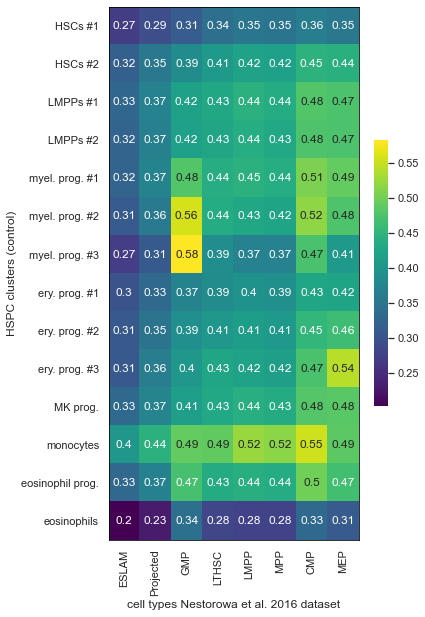

In [22]:
### create figure with Pearson correlations
fig, axs = plt.subplots(1,1,figsize=(pearson_corr.shape[1]*0.7,pearson_corr.shape[0]*0.7))

heatmap = sns.heatmap(pearson_corr.iloc[:,leaves_list(B)], 
                      cmap="viridis", cbar_kws={"shrink": 0.5},
                      annot=True)
axs.set_xlabel("cell types Nestorowa et al. 2016 dataset")
axs.set_ylabel("HSPC clusters (control)")
axs.yaxis.set_label_position("left")

for spine in axs.spines.values():
    spine.set(visible=True, lw=.8, edgecolor="black")

save_path = "../figures/1.2.5.Pearson_correlation_Nestorowa_vs_control.pdf"
fig.savefig(save_path, bbox_inches='tight', format='pdf', dpi=300)

plt.show()